# RNN Time Series example using Tensorflow
Justin Brandenburg, MapR Technologies

In [1]:
#What are we working with?
import sys
sys.version

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1500400165929_0603,pyspark,idle,Link,Link,✔


SparkSession available as 'spark'.
'2.7.6 (default, Oct 26 2016, 20:30:19) \n[GCC 4.8.4]'

In [3]:
%%local
import sys
sys.version

'2.7.9 (default, Jun 29 2016, 13:08:31) \n[GCC 4.9.2]'

In [6]:
%%local
!sudo apt-get install -y python-tk

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following extra packages will be installed:
  blt tk8.6-blt2.5
Suggested packages:
  blt-demo tix python-tk-dbg
The following NEW packages will be installed:
  blt python-tk tk8.6-blt2.5
0 upgraded, 3 newly installed, 0 to remove and 0 not upgraded.
Need to get 627 kB of archives.
After this operation, 2122 kB of additional disk space will be used.
Get:1 http://httpredir.debian.org/debian/ jessie/main tk8.6-blt2.5 amd64 2.5.3+dfsg-1 [586 kB]
Get:2 http://httpredir.debian.org/debian/ jessie/main blt amd64 2.5.3+dfsg-1 [14.3 kB]
Get:3 http://httpredir.debian.org/debian/ jessie/main python-tk amd64 2.7.8-2+b1 [26.7 kB]
Fetched 627 kB in 0s (769 kB/s) 
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 3.)
debconf: falling back to fron

In [1]:
%%local
#Import Libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
from matplotlib import pyplot as plt
import random
%matplotlib inline
import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

In [2]:
%%local
#TF Version
tf.__version__

'1.3.0'

#### Generate some data

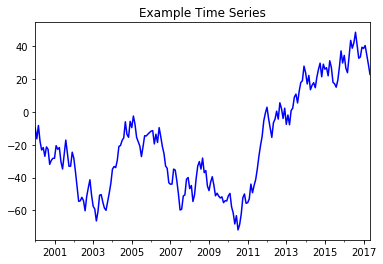

2000-01-31    -9.909385
2000-02-29   -16.431887
2000-03-31    -8.332938
2000-04-30   -17.928518
2000-05-31   -23.255403
2000-06-30   -21.769311
2000-07-31   -27.077233
2000-08-31   -21.388962
2000-09-30   -22.846678
2000-10-31   -31.960037
Freq: M, dtype: float64

In [3]:
%%local
random.seed(111)
rng = pd.date_range(start='2000', periods=209, freq='M')
ts = pd.Series(np.random.uniform(-10, 10, size=len(rng)), rng).cumsum()
ts.plot(c='b', title='Example Time Series')
plt.show()
ts.head(10)

#### Convert data into array that can be broken up into training "batches" that we will feed into our RNN model.  Note the shape of the arrays. 

In [4]:
%%local
TS = np.array(ts)
num_periods = 20
f_horizon = 1  #forecast horizon, one period into the future

x_data = TS[:(len(TS)-(len(TS) % num_periods))]
x_batches = x_data.reshape(-1, 20, 1)

y_data = TS[1:(len(TS)-(len(TS) % num_periods))+f_horizon]
y_batches = y_data.reshape(-1, 20, 1)
print (len(x_batches))
print (x_batches.shape)
print (x_batches[0:2])

print (y_batches[0:1])
print (y_batches.shape)

10
(10, 20, 1)
[[[ -9.9093845 ]
  [-16.43188724]
  [ -8.33293811]
  [-17.92851754]
  [-23.25540262]
  [-21.76931099]
  [-27.07723252]
  [-21.38896232]
  [-22.84667792]
  [-31.96003735]
  [-29.54904238]
  [-28.27734157]
  [-28.27063509]
  [-20.60473066]
  [-22.81311389]
  [-21.76884369]
  [-30.37410137]
  [-34.80888329]
  [-26.19473843]
  [-17.22574023]]

 [[-25.33084418]
  [-33.16637651]
  [-33.09204536]
  [-24.5732529 ]
  [-28.29355013]
  [-36.37545339]
  [-45.6139316 ]
  [-54.50552929]
  [-54.16124323]
  [-52.05169061]
  [-54.07525545]
  [-60.2019048 ]
  [-51.51492681]
  [-46.20357978]
  [-41.36695176]
  [-50.59354688]
  [-57.44017883]
  [-59.14851765]
  [-66.40629156]
  [-60.68086555]]]
[[[-16.43188724]
  [ -8.33293811]
  [-17.92851754]
  [-23.25540262]
  [-21.76931099]
  [-27.07723252]
  [-21.38896232]
  [-22.84667792]
  [-31.96003735]
  [-29.54904238]
  [-28.27734157]
  [-28.27063509]
  [-20.60473066]
  [-22.81311389]
  [-21.76884369]
  [-30.37410137]
  [-34.80888329]
  [-26.19473

#### Pull out our test data

In [5]:
%%local
def test_data(series,forecast,num_periods):
    test_x_setup = TS[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, 20, 1)
    testY = TS[-(num_periods):].reshape(-1, 20, 1)
    return testX,testY

X_test, Y_test = test_data(TS,f_horizon,num_periods )
print (X_test.shape)
print (X_test)

(1, 20, 1)
[[[ 19.23523732]
  [ 27.27811184]
  [ 37.05181297]
  [ 29.70517091]
  [ 34.31617816]
  [ 26.56826257]
  [ 23.78820275]
  [ 33.50471907]
  [ 43.46957487]
  [ 38.70542305]
  [ 42.02756436]
  [ 48.40160992]
  [ 40.36852439]
  [ 32.57708561]
  [ 33.35693414]
  [ 39.28415399]
  [ 38.56647957]
  [ 40.2878574 ]
  [ 34.57850683]
  [ 28.82838625]]]


In [76]:
%%local
tf.reset_default_graph()   #We didn't have any previous graph objects running, but this would reset the graphs

num_periods = 20      #number of periods per vector we are using to predict one period ahead
inputs = 1            #number of vectors submitted
hidden = 100          #number of neurons we will recursively work through, can be changed to improve accuracy
output = 1            #number of output vectors

X = tf.placeholder(tf.float32, [None, num_periods, inputs])   #create variable objects
y = tf.placeholder(tf.float32, [None, num_periods, output])


basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)   #create our RNN object
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)               #choose dynamic over static

learning_rate = 0.001   #small learning rate so we don't overshoot the minimum

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])           #change the form into a tensor
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)        #specify the type of layer (dense)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])          #shape of results
 
loss = tf.reduce_sum(tf.square(outputs - y))    #define the cost function which evaluates the quality of our model
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)          #gradient descent method
training_op = optimizer.minimize(loss)          #train the result of the application of the cost_function                                 

init = tf.global_variables_initializer()           #initialize all the variables

In [77]:
epochs = 1000     #number of iterations or training cycles, includes both the FeedFoward and Backpropogation

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            print(ep, "\tMSE:", mse)
    
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    print(y_pred)

0 	MSE: 724844.0
100 	MSE: 19297.0
200 	MSE: 10030.5
300 	MSE: 4453.94
400 	MSE: 2486.23
500 	MSE: 1849.27
600 	MSE: 1537.43
700 	MSE: 1365.78
800 	MSE: 1141.08
900 	MSE: 1062.75
[[[ -65.43389893]
  [ -70.15782166]
  [ -74.97548676]
  [ -76.0067215 ]
  [ -80.11599731]
  [ -87.79607391]
  [ -98.87727356]
  [-100.79344177]
  [ -96.78859711]
  [ -88.2572937 ]
  [ -89.33888245]
  [ -98.35159302]
  [-113.49594879]
  [-103.05888367]
  [ -92.25975037]
  [ -93.55337524]
  [-113.38123322]
  [-112.15855408]
  [ -85.15632629]
  [ -60.79482269]]]


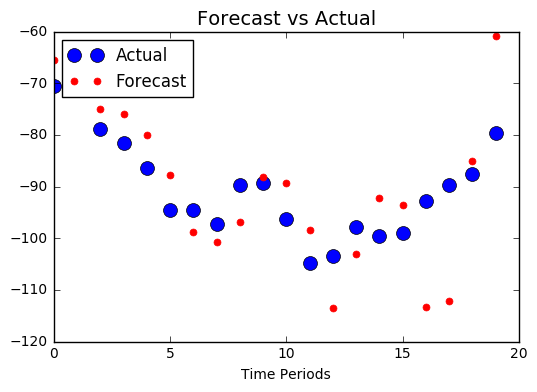

In [78]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), "bo", markersize=10, label="Actual")
#plt.plot(pd.Series(np.ravel(Y_test)), "w*", markersize=10)
plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize=10, label="Forecast")
plt.legend(loc="upper left")
plt.xlabel("Time Periods")

plt.show()

